In [22]:
import os
import sys
import numpy as np
#import segmentation_models_pytorch as smp
import tifffile
import albumentations as A
from matplotlib import pyplot as plt
import skimage.io
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
sys.path.append("..") 

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import tqdm

import segmentation_models_p as sp

In [23]:
# Ancak şu aşamada unclassified sınıfı da var. 
palette ={ 0 : (0,0,0), #nodata
           1 : (255,0,0), #discontinious urban fabric
           2 : (255,255,168),  #non irrigated arable land and mixed forest 
           3 : (230,128,0),  # vineyards
           4 : (242,166,77), #fruit trees and berry plantations 
           5 : (230,166,0),  #olive groves
           6 : (230,230,77), # pastures
           7 : (77,255,0),  #mixed forest
           8 : (204,255,204),  #sparsely vegetated areas
           9: (128,242,230), # water bodies
           10: (204,0,0) #road and rail networks and associated land
        }
         
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# helper function for data visualization
def visualize_in_one_row(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def evaluate(model, generator):
    """ usage:
        from sklearn.metrics import classification_report
        y_pred, y = evaluate(best_model, generator)
        y_pred  = np.hstack(y_pred)
        y = np.hstack(y)
        targets = ['building', 'not_building']
        print(classification_report(y, y_pred, target_names = targets))#, output_dict = True)
    """
    
    best_model = model
    best_model.cuda()
    best_model.eval()

    y_preds = list()
    ys = list()
    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(generator))):
            X,y = generator[idx]
            #X = X.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            gt_max = np.argmax(y, axis=0)
            #gt_colora = convert_to_color(gt_max)
            logsoftmax = best_model.forward(X[None,:,:])
            y_pred = logsoftmax.argmax(dim=1)
            y_pred = y_pred.squeeze()
            gt_color = torch.as_tensor(gt_max).cuda()
            gt_color = gt_color.detach().cpu().numpy().flatten()
            y= gt_color 
            y_pred = y_pred.flatten().detach().cpu().numpy()
            
            ys.append(y)
            y_preds.append(y_pred)
            
    best_model.cpu()
    return y_preds, ys    


Class_names = ['NaN', 
                 'Discontinious urban fabric',
                 'Non irrigated arable land and mixed forest',
                 'Vineyard', 
                 'Fruit trees and berry plantations', 
                 'Olive groves',
                 'Pastures',
                 'Mixed forest',
                 'Sparsely vegetated areas',
                 'Water Bodies',
                  'Road and rail networks and associated land']

In [24]:
class MM_Dataset(Dataset):  
    def __init__(
            self, 
            dataset_dir,
            mode,
            transform=None, 
            preprocessing=None,
            sample_ids=False):

        self.dataset_dir = dataset_dir
        self.transform = transform
        self.preprocessing = preprocessing
        self.class_values = np.arange(0,11,1) 
        self.sample_ids = sample_ids
        
        if mode == 'train':
            
            self.train_dir = os.path.join(self.dataset_dir, 'Train')
            
            optic_dir = os.path.join(self.train_dir, 'Image')
            mask_dir = os.path.join(self.train_dir, 'Mask')
            
            self.optic_ids = os.listdir(optic_dir)
            self.mask_ids = os.listdir(mask_dir)

            self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
            self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
            print("Training set: {} image".format(len(self.optic_ids)))
            
        if mode == 'val':
            
            self.train_dir = os.path.join(self.dataset_dir, 'Validation')
            
            optic_dir = os.path.join(self.train_dir, 'Image')
            mask_dir = os.path.join(self.train_dir, 'Mask')
            
            self.optic_ids = os.listdir(optic_dir)
            self.mask_ids = os.listdir(mask_dir)

            self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
            self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
            print("Validation set: {} image".format(len(self.optic_ids)))
            
        elif mode == 'test':
            
            self.test_dir = os.path.join(self.dataset_dir, 'Test')
            
            optic_dir = os.path.join(self.test_dir, 'Image')
            mask_dir = os.path.join(self.test_dir, 'Mask')
            
            self.optic_ids = os.listdir(optic_dir)
            self.mask_ids = os.listdir(mask_dir)

            self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
            self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
            print("Test set: {} image".format(len(self.optic_ids)))

    @staticmethod
    def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

    def __len__(self):
        return len(self.mask_ids)
    
    def __getitem__(self, idx):
                         
        optic_id = self.optic_fps[idx].split('\\')[-1]
        mask_id = self.mask_fps[idx].split('\\')[-1]

        optic_filepath = self.optic_fps[idx]
        mask_filepath = self.mask_fps[idx]
            
        image = self._read_img(optic_filepath)
        mask = self._read_img(mask_filepath)  

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        if self.preprocessing:
            preprocessed  = self.preprocessing(image=image, mask=mask)
            image,mask = preprocessed['image'], preprocessed['mask']
            
        mask_raw = convert_from_color(mask)
        masks = [(mask_raw == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1) 
        
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)
        
        image = torch.as_tensor(image, dtype=torch.float).cuda()
        mask = torch.as_tensor(mask, dtype=torch.float).cuda()
        
        if self.sample_ids is not False:
            return image,mask,optic_id, optic_filepath
        
        return image, mask

In [25]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(512,512),
        A.RandomRotate90(),
        A.Flip(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        #A.Normalize(mean=(415, 498, 508, 656),
        #            std=(203,202,178,281)),
    ]
)

val_transform =  A.Compose([ A.PadIfNeeded(512,512),
         #             A.Normalize(mean=(436,512,516,688),
         #                       std=(216,214,189,292)),
                                ])

test_transform =  A.Compose([ A.PadIfNeeded(512, 512),
          #            A.Normalize(mean=(432,506,512,668),
          #                      std=(218,215,189,285)),
                                ])

In [26]:
SEED = 33
seed_everything(SEED)
dataset_dir = r"C:\Users\CBS-7\Desktop\Harita\DATA\Dataset"

In [27]:
train_dataset = MM_Dataset(dataset_dir = dataset_dir,
                    mode='train',
                    transform = train_transform)

val_dataset = MM_Dataset(dataset_dir = dataset_dir,
                    mode='val',
                    transform = val_transform)

test_dataset = MM_Dataset(dataset_dir = dataset_dir,
                    mode='test',
                    transform = test_transform)

Training set: 658 image
Validation set: 188 image
Test set: 94 image


In [28]:
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for mask in dataset.mask_fps:
      mask = fs.read_image_as_is(mask)
      unique_labels = np.unique(mask)
      labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

In [29]:
mul_factor =  5
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([11, 512, 512])


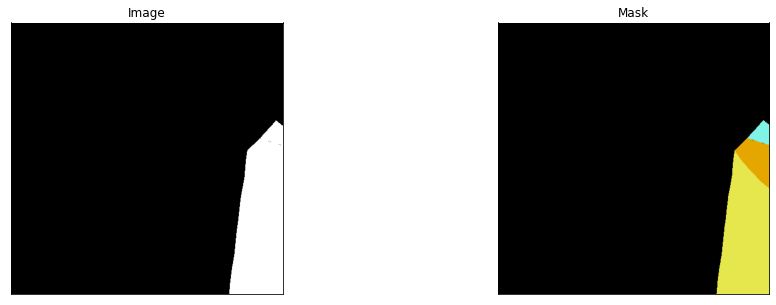

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([11, 512, 512])


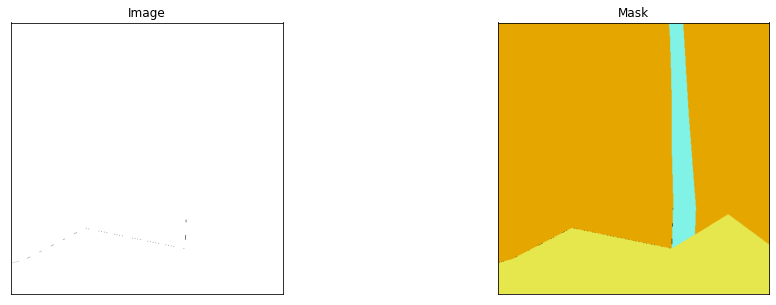

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([11, 512, 512])


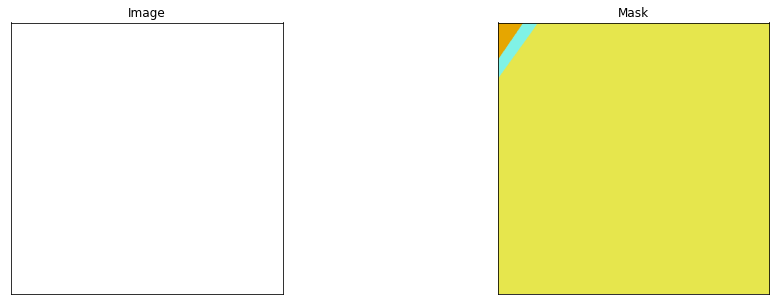

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([11, 512, 512])


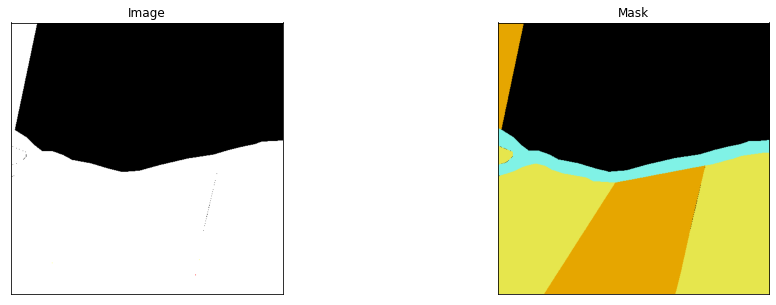

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([11, 512, 512])


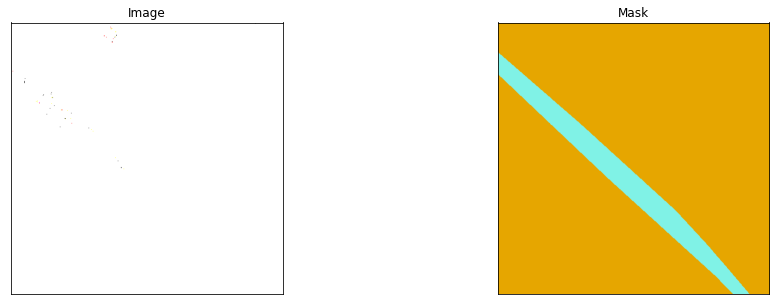

In [30]:
for i in range(5):
    
    idx = np.random.randint(0,len(train_dataset))
    image, mask = train_dataset[idx]
    print(image.shape, mask.shape)
    im = image.detach().cpu().numpy()
    image = np.transpose(im, (1,2,0))
    
    mask = mask.detach().cpu().numpy()
    
    gt_mask = np.transpose(mask, (1,2,0))
    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)    
    
    visualize_in_one_row(Image = image,
                         Mask = gt_color)

In [31]:
focal = sp.losses.FocalLoss(mode='multilabel',ignore_index = [0])
focal.__name__ = 'Focal'

dice = sp.losses.DiceLoss(mode = 'multilabel',ignore_index = [0])
dice.__name__ = 'Dice'

from pytorch_toolbelt.losses import JointLoss

loss = JointLoss(dice, focal, 1.0, 0.5)
loss.__name__ ="DF"

### Hyperparameters

In [32]:
n_classes = len(palette)
activation = 'softmax'
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
batch_s = 2
in_ch = 3
lr = 2e-4
n_of_epochs = 250
log_path = r"C:\Users\CBS-7\Desktop\Harita\Outputs\logs"
experiment_log = 'Kestel_Map_dlv3_rxt101'

In [33]:
net = sp.DeepLabV3Plus(ENCODER, classes=n_classes, activation=activation, in_channels=in_ch,encoder_weights=ENCODER_WEIGHTS )

In [34]:
net = net.cuda()

In [35]:
train_loader = DataLoader(train_dataset, batch_size=batch_s, sampler = train_sampler)#, shuffle=True)#, collate_fn=collate_fn)
valid_loader = DataLoader(val_dataset, batch_size=batch_s, shuffle=False)#, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)#, collate_fn=collate_fn)

In [15]:
metrics = [sp.utils.metrics.IoU(threshold=0.5, ignore_channels = [0]), 
            sp.utils.metrics.Fscore(threshold=0.5, ignore_channels = [0]),
            sp.utils.metrics.Precision(threshold=0.5, ignore_channels = [0]),
            sp.utils.metrics.Recall(threshold=0.5, ignore_channels = [0])
]

optimizer = torch.optim.Adam([ 
    dict(params=net.parameters(), lr=lr),
])

In [16]:
train_epoch = sp.utils.train.TrainEpoch(
    net, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = sp.utils.train.ValidEpoch(
    net, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#### train

In [ ]:
max_score = 0

for i in range(0, n_of_epochs):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(net, os.path.join(log_path, '.\{}.pth'.format(experiment_log)))
        print('Model saved!')


Epoch: 0
train:   0%|                                                                                  | 0/1645 [00:00<?, ?it/s]

C:\Users\CBS-7\Desktop\Harita\segmentation_models_p\base\modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


train: 100%|█| 1645/1645 [20:08<00:00,  1.36it/s, DF - 0.4466, iou_score - 0.5373, fscore - 0.6631, precision - 0.6898,
valid:  62%|▌| 58/94 [00:14<00:09,  3.94it/s, DF - 0.3986, iou_score - 0.7537, fscore - 0.8373, precision - 0.8435, rec

In [36]:
best_model = torch.load(os.path.join(log_path, '.\{}.pth'.format(experiment_log)))

In [37]:
best_model.cuda()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [38]:
test_epoch = sp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 47/47 [00:29<00:00,  1.57it/s, DF - 0.3398, iou_score - 0.905, fscore - 0.9437, precision - 0.9447, reca


In [39]:
logs

{'DF': 0.3397753035768549,
 'iou_score': 0.9050053668783066,
 'fscore': 0.9437065390830344,
 'precision': 0.9447071260594305,
 'recall': 0.9428898882358632}

<ipython-input-41-a6d0b4cbc541>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
<ipython-input-41-a6d0b4cbc541>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor, device = 'cuda')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


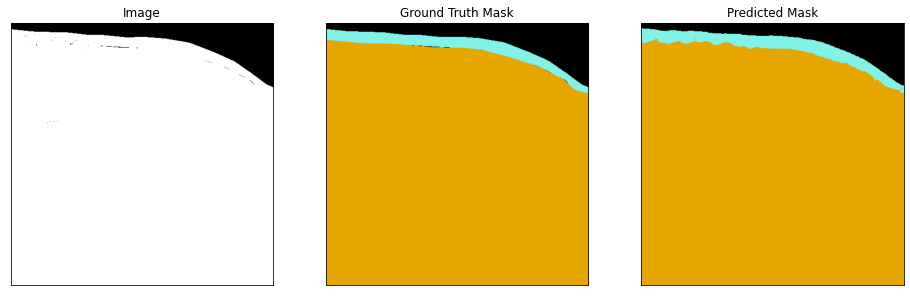

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


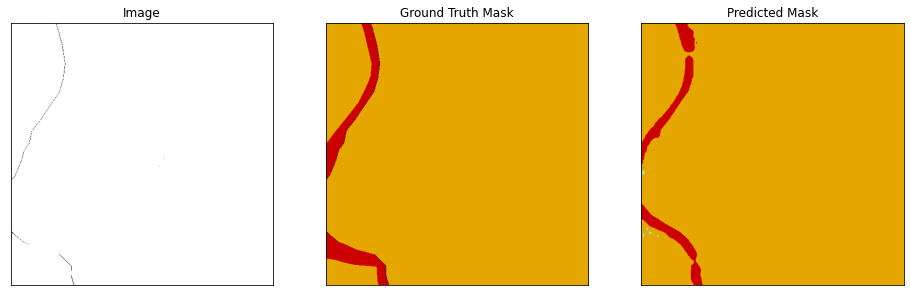

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


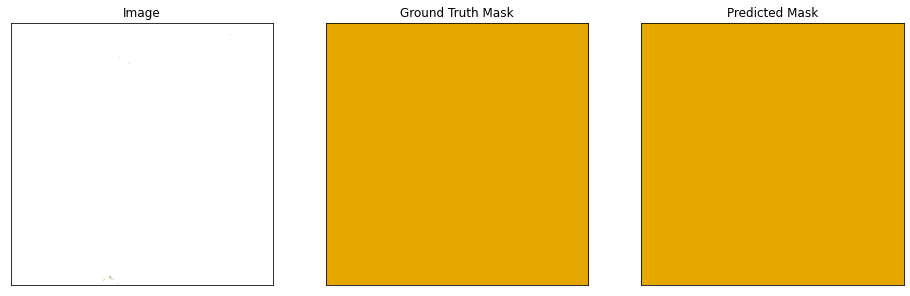

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


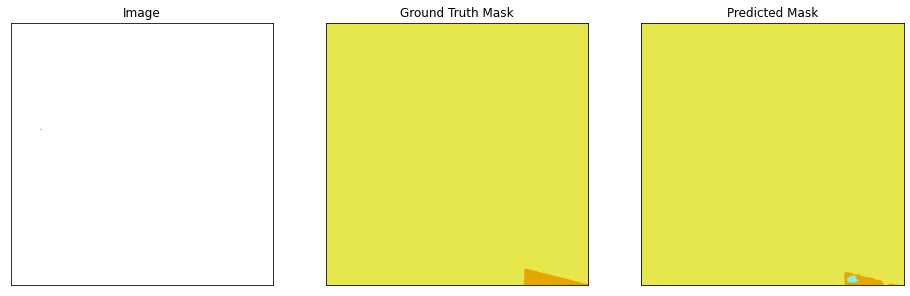

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


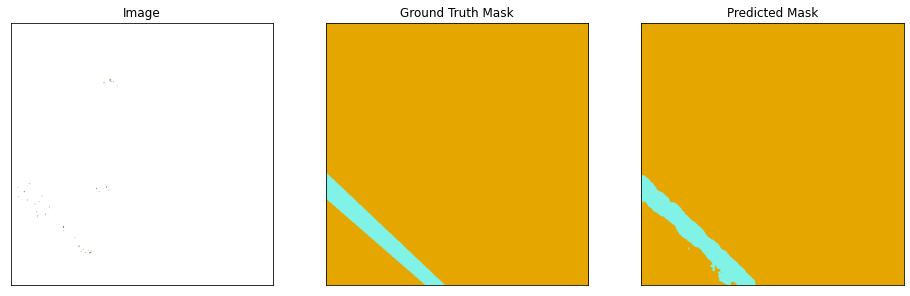

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


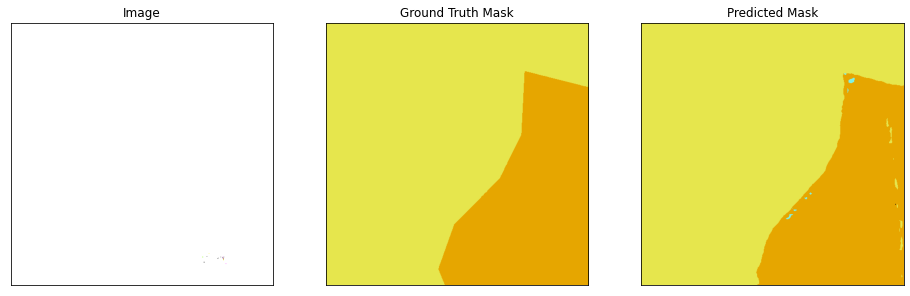

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


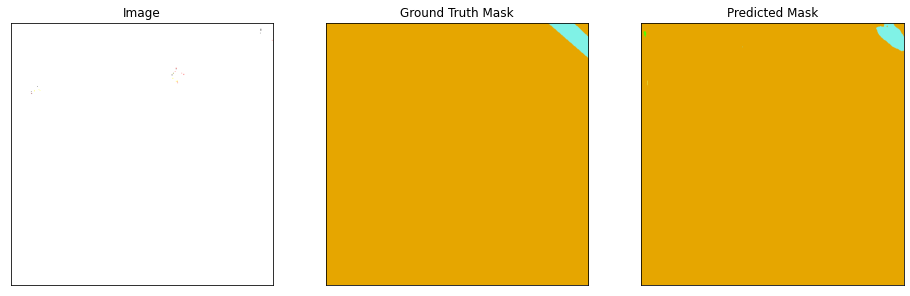

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


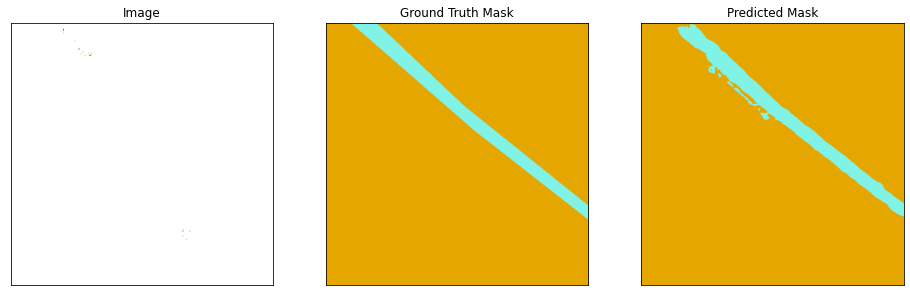

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


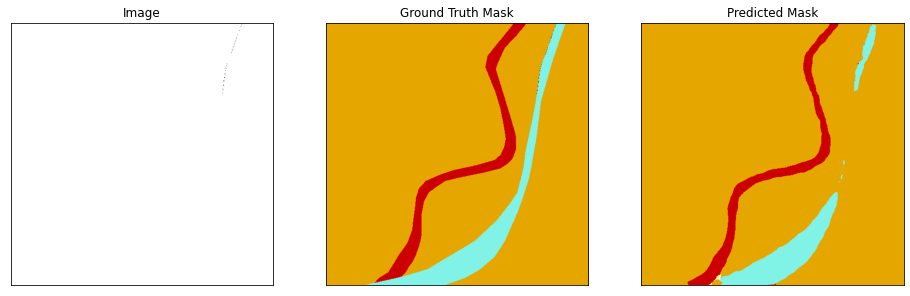

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


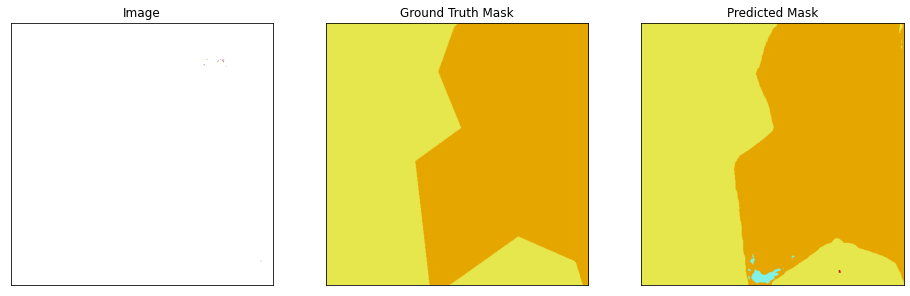

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


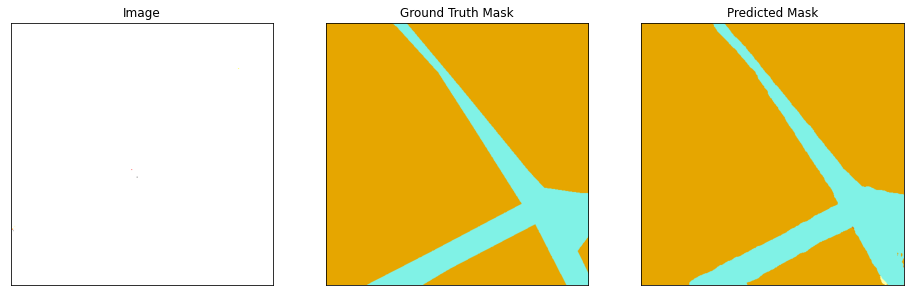

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


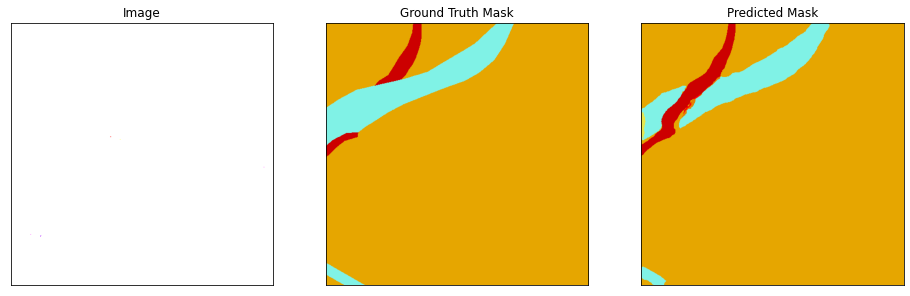

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


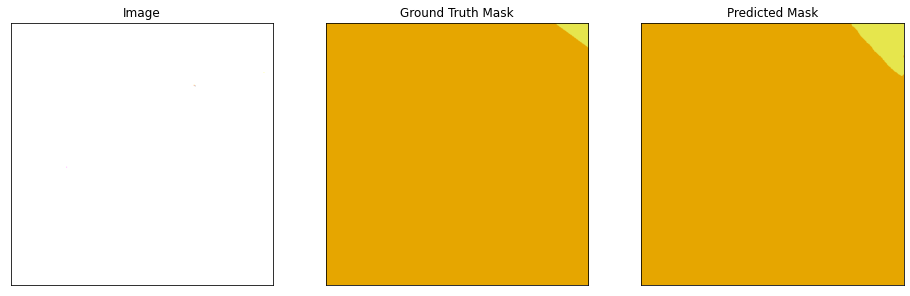

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


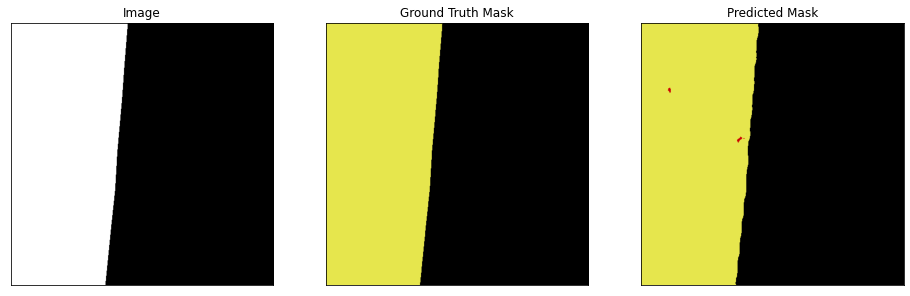

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


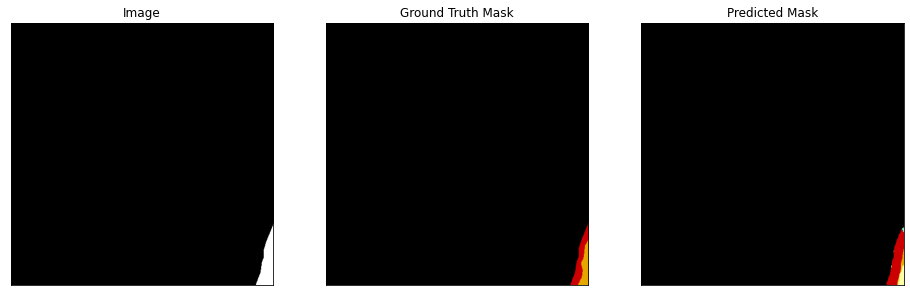

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


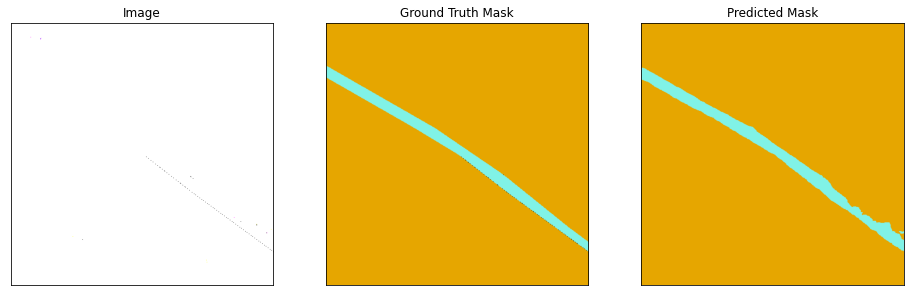

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


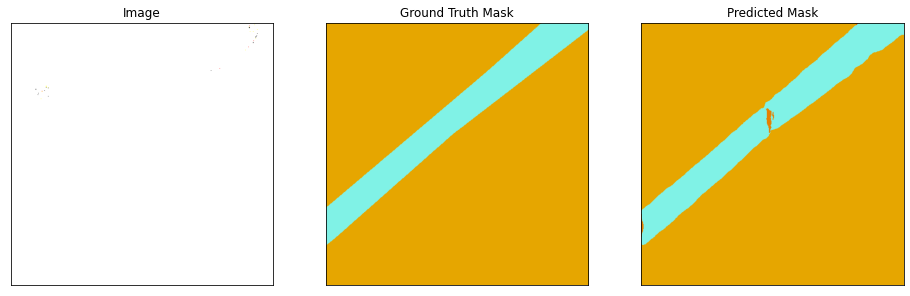

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


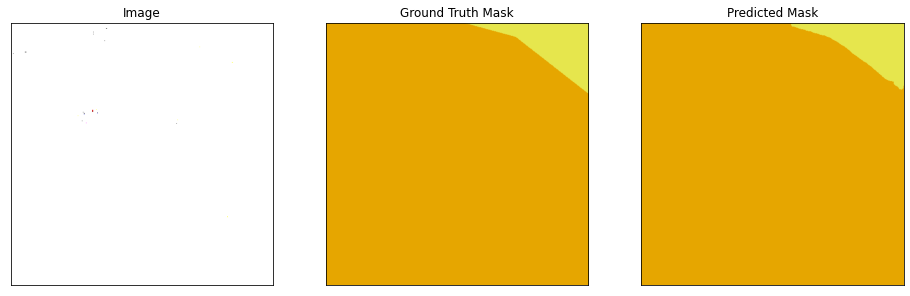

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


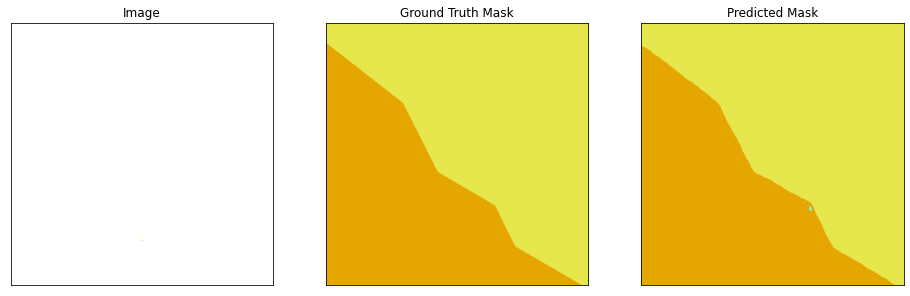

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


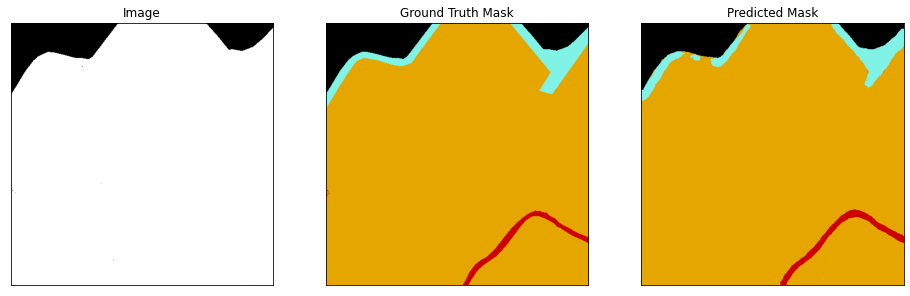

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


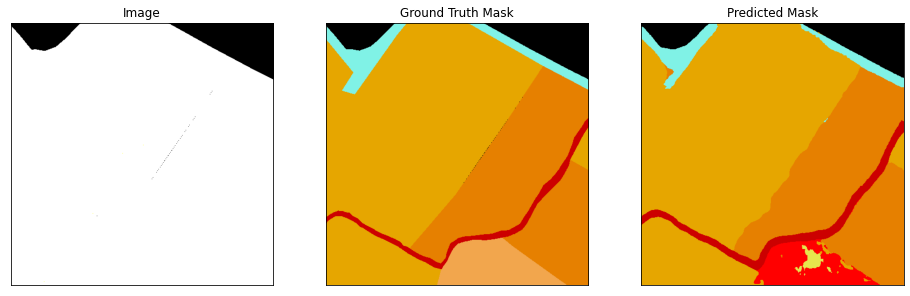

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


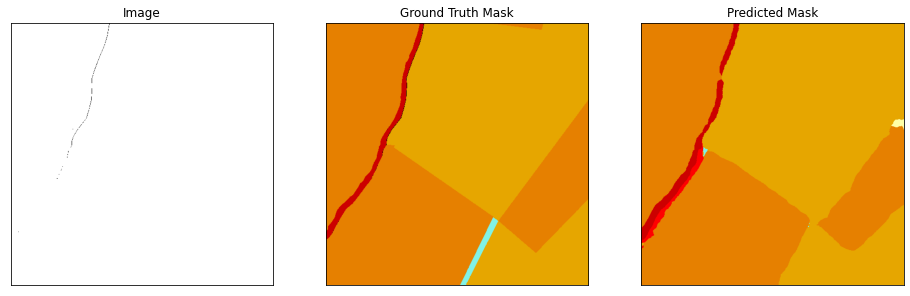

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


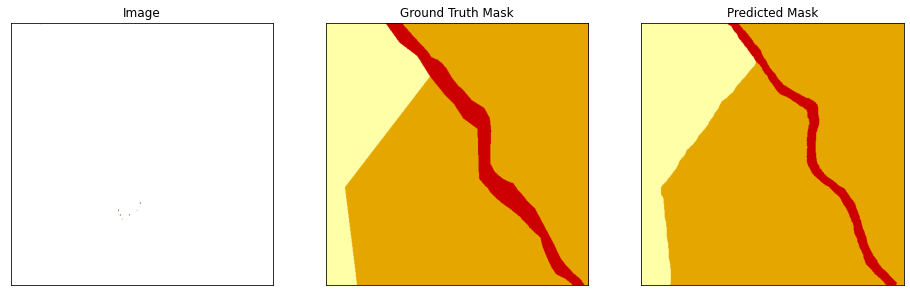

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


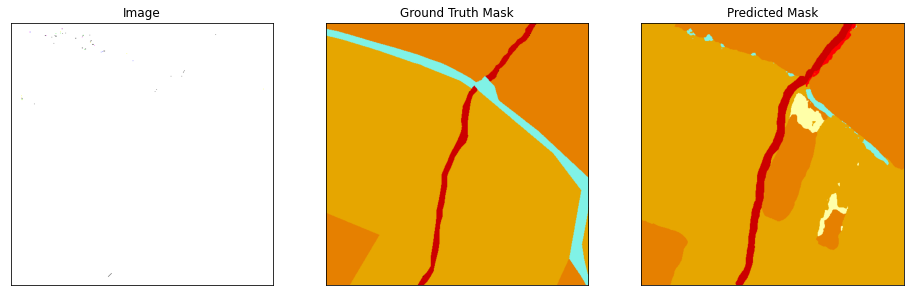

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


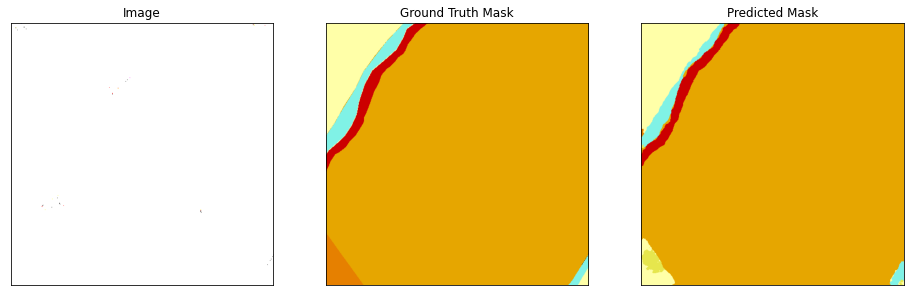

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


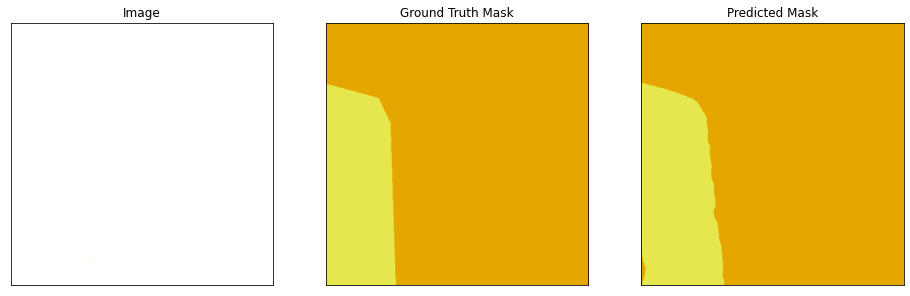

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


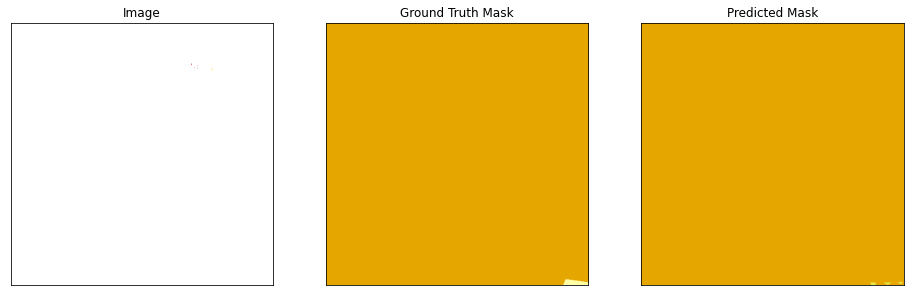

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


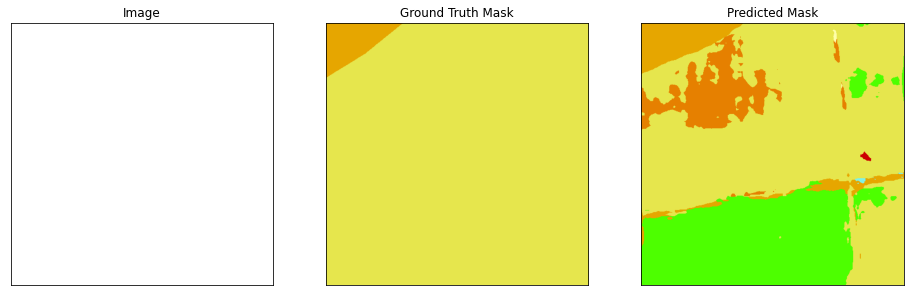

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


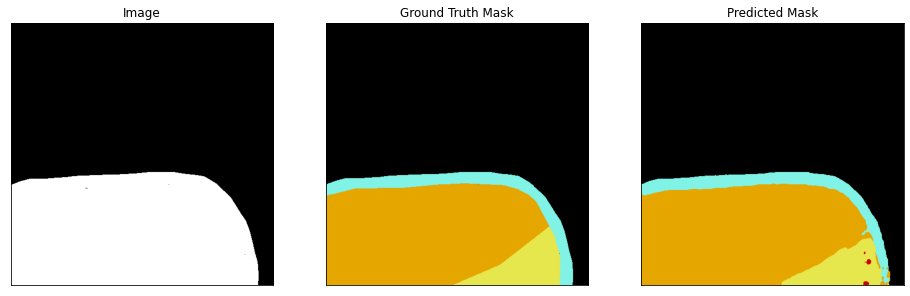

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


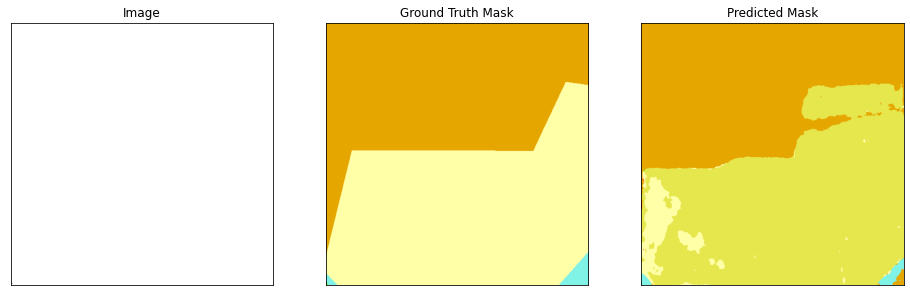

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


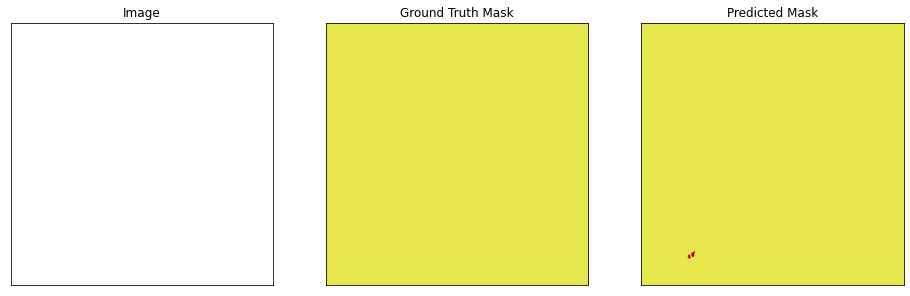

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


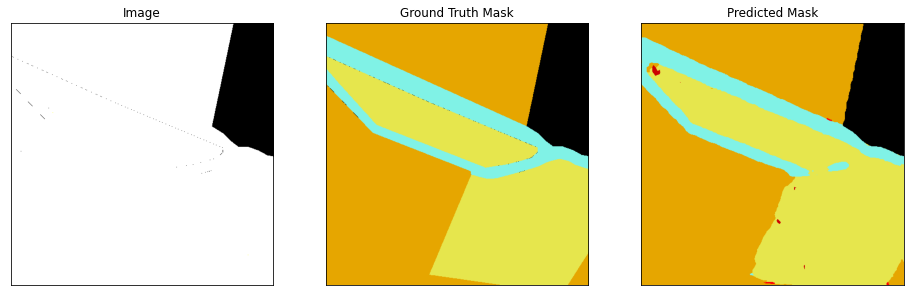

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


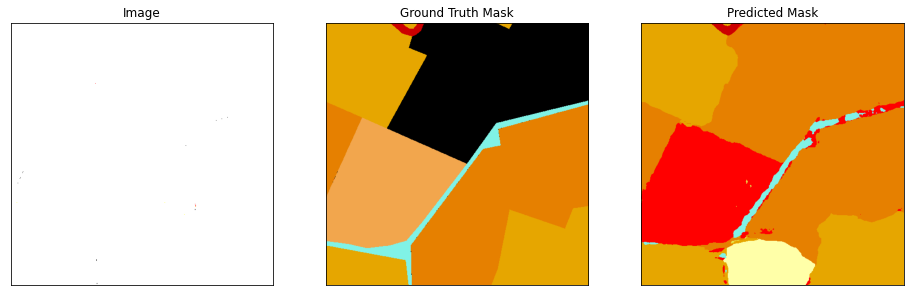

KeyboardInterrupt: 

In [41]:
for i in range(len(test_dataset)):
        
    image = np.transpose(test_dataset[i][0].detach().cpu().numpy(),(1,2,0))
    viz_im = image
    
    gt_mask = np.transpose(test_dataset[i][1].detach().cpu().numpy(),(1,2,0))
    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)    

    x_tensor = test_dataset[i][0]
    tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
    tensor = tensor.float() 
    tensor = torch.tensor(tensor, device = 'cuda')

    pr_mask = best_model.predict(tensor).detach().cpu().numpy()
    pr_max  = np.argmax(pr_mask, 1)
    pr_max = np.transpose(pr_max, (1,2,0)).squeeze()
    pr_max11 = convert_to_color(pr_max)

    visualize_in_one_row(
            image=viz_im,  #ımage torch.Size([512, 512, 4])
            ground_truth_mask=gt_color,  #gt_color (512, 512, 3)
            predicted_mask=pr_max11) #pr_max11 (512, 512, 3)

## Class-wise metrics

In [ ]:
y_preds, ys = evaluate(best_model, test_dataset)

In [ ]:
y_preds = np.asarray(y_preds)
ys = np.asarray(ys)

F1 = f1_score(ys.flatten(), y_preds.flatten(), average=None)
Precision = precision_score(ys.flatten(), y_preds.flatten(), average=None)
Recall = recall_score(ys.flatten(), y_preds.flatten(), average=None)
a = (F1.flatten(), Precision.flatten(), Recall.flatten())

f1 = np.asarray(F1)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, prec, rec), axis = 1)
metrics

In [ ]:
f1

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib 
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix 

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 22,
              'xtick.labelsize':27,
              'ytick.labelsize':27}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten())

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
           
    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper') 
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
           #ylabel='True label',
           #xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig('Confusion-NWPU_enumerated_FINAL.svg', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

In [ ]:
plot_confusion_matrix(ys=ys,
                      y_preds=y_preds,
                      classes=Class_names,
                      normalize=True)

## dataset preperation 

In [ ]:
import skimage.io as io
import numpy as np
from matplotlib import pyplot as plt
import os

In [ ]:
import skimage
def _read_img(image_path):
    img = skimage.io.imread(image_path, plugin='tifffile')
    return img

In [ ]:
ima = _read_img(r"C:\Users\CBS-7\Desktop\Harita\clipp\mask_clipt\mask_clip.tif")

In [ ]:
palette ={ 0 : (0,0,0), #nodata
           1 : (255,0,0), #discontinious urban fabric
           2 : (255,255,168),  #non irrigated arable land and mixed forest 
           3 : (230,128,0),  # vineyards
           4 : (242,166,77), #fruit trees and berry plantations 
           5 : (230,166,0),  #olive groves
           6 : (230,230,77), # pastures
           7 : (77,255,0),  #mixed forest
           8 : (204,255,204),  #sparsely vegetated areas
           9: (128,242,230), # water bodies
           10: (204,0,0) #road and rail networks and associated land
        }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

In [ ]:
a,b  = np.unique(ima, return_counts=True)

In [ ]:
a,b

In [ ]:
colored_mask = convert_to_color(ima)

plt.imshow(colored_mask)

In [ ]:
save_path = r"C:\Users\CBS-7\Desktop\Harita\clipp\mask_clipt\Colored_mask\GT_colored.tif"

io.imsave(save_path, colored_mask) #no CRS 

In [ ]:
patches_dir = r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches"

In [ ]:
import os
import skimage.io
import numpy as np
import glob
import shutil

In [ ]:
#original
def _read_img(image_path):
    img = skimage.io.imread(image_path, plugin='tifffile')
    return img

deleted_ids = []

path = r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches\Mask\tif"
for filename in os.listdir(path):
    img = _read_img(path + '\\' + filename)
    sum_of_pixels = np.sum(img)
    if sum_of_pixels == 0 or img.shape[0] != img.shape[1]:
        last = filename.split('.')[0].split('_')[-1]
        before = filename.split('.')[0].split('_')[-2]
        id_ = before + '_' + last
        deleted_ids.append(id_)
        os.remove(path + '\\' + filename)

In [ ]:
len(deleted_ids) # 1368 -> 940

In [ ]:
deleted_ids

In [ ]:
for i in range(len(os.listdir(r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches\Image\tif"))):
    for fileloc in glob.iglob(r'C:\Users\CBS-7\Desktop\Harita\DATA\Patches\Image\tif\map_clipped__{}.tif'.format(deleted_ids[i])):
        os.remove(fileloc)

### Split  

In [ ]:
ids__ = os.listdir(r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches\Mask\tif")
all_ids = []

for x,i in enumerate(ids__):
    last = ids__[x].split('.')[0].split('_')[-1]
    before = ids__[x].split('.')[0].split('_')[-2]
    id_ = before + '_' + last
    all_ids.append(id_)

    
val_ratio = 0.2
test_ratio = 0.1

#np.random.seed(344)
np.random.shuffle(all_ids)

train_FileNames, val_FileNames, test_FileNames = np.split(np.array(all_ids),
                                                              [int(len(all_ids)* (1 - (val_ratio + test_ratio))), 
                                                               int(len(all_ids)* (1 - test_ratio))])

In [ ]:
all_ids

In [ ]:
train_FileNames

In [ ]:
len(train_FileNames), len(val_FileNames), len(test_FileNames)

In [ ]:
dirr_mask = r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches\Mask\tif"

all_fn_train = ['GT_colored_{}.tif'.format(name) for name in train_FileNames]
all_fn_val = ['GT_colored_{}.tif'.format(name) for name in val_FileNames]
all_fn_test = ['GT_colored_{}.tif'.format(name) for name in test_FileNames]

train_mask = [os.path.join(dirr_mask, all_fn_train[i]) for i, name in enumerate(train_FileNames)]
val_mask = [os.path.join(dirr_mask, all_fn_val[i]) for i, name in enumerate(val_FileNames)]
test_mask = [os.path.join(dirr_mask, all_fn_test[i]) for i, name in enumerate(test_FileNames)]
#train_mask

In [ ]:
dirr_optic = r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches\Image\tif"

all_fn_train = ['map_clipped__{}.tif'.format(name) for name in train_FileNames]
all_fn_val = ['map_clipped__{}.tif'.format(name) for name in val_FileNames]
all_fn_test = ['map_clipped__{}.tif'.format(name) for name in test_FileNames]

train_optic = [os.path.join(dirr_optic, all_fn_train[i]) for i, name in enumerate(train_FileNames)]
val_optic = [os.path.join(dirr_optic, all_fn_val[i]) for i, name in enumerate(val_FileNames)]
test_optic = [os.path.join(dirr_optic, all_fn_test[i]) for i, name in enumerate(test_FileNames)]

In [ ]:
#ORIGINAL ONE

root_dir = r'C:\Users\CBS-7\Desktop\Harita\DATA\Dataset' # data root path
classes_dir = ['Mask'] #total labels

val_ratio = 0.2
test_ratio = 0.1

for cls in classes_dir:

    src = os.path.join(r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches", cls) # Folder to copy images from

    allFileNames = os.listdir(src)

    np.random.shuffle(allFileNames)

    train_FileNames = train_mask
    val_FileNames = val_mask
    test_FileNames = test_mask

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, (os.path.join(root_dir,'Train',cls)))

    for name in val_FileNames:
        shutil.copy(name, (os.path.join(root_dir,'Validation',cls)))

    for name in test_FileNames:
        shutil.copy(name,(os.path.join(root_dir,'Test',cls)))

In [ ]:
#ORIGINAL ONE

root_dir = r'C:\Users\CBS-7\Desktop\Harita\DATA\Dataset' # data root path
classes_dir = ['Image'] #total labels

val_ratio = 0.2
test_ratio = 0.1

for cls in classes_dir:

    src = os.path.join(r"C:\Users\CBS-7\Desktop\Harita\DATA\Patches", cls) # Folder to copy images from

    allFileNames = os.listdir(src)

    np.random.shuffle(allFileNames)

    train_FileNames = train_optic
    val_FileNames = val_optic
    test_FileNames = test_optic

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, (os.path.join(root_dir,'Train',cls)))

    for name in val_FileNames:
        shutil.copy(name, (os.path.join(root_dir,'Validation',cls)))

    for name in test_FileNames:
        shutil.copy(name,(os.path.join(root_dir,'Test',cls)))

## check

In [ ]:
palette ={ 0 : (0,0,0), #nodata
           1 : (255,0,0), #discontinious urban fabric
           2 : (255,255,168),  #non irrigated arable land and mixed forest 
           3 : (230,128,0),  # vineyards
           4 : (242,166,77), #fruit trees and berry plantations 
           5 : (230,166,0),  #olive groves
           6 : (230,230,77), # pastures
           7 : (77,255,0),  #mixed forest
           8 : (204,255,204),  #sparsely vegetated areas
           9: (128,242,230), # water bodies
           10: (204,0,0) #road and rail networks and associated land
        }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# helper function for data visualization
def visualize_in_one_row(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
import os
import numpy as np
import tifffile
from matplotlib import pyplot as plt

class Dataset():
    
    def __init__(
            self, 
            dataset_dir):
        
        self.dataset_dir = dataset_dir        
        self.train_dir = os.path.join(self.dataset_dir, 'Train')
            
        optic_dir = os.path.join(self.train_dir, 'Image')
        mask_dir = os.path.join(self.train_dir, 'Mask')
            
        self.optic_ids = os.listdir(optic_dir)
        self.mask_ids = os.listdir(mask_dir)

        self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
        self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
        print("There are : {} images in this set".format(len(self.optic_ids)))
            
    def __getitem__(self, i):
        
        optic = tifffile.imread(self.optic_fps[i])
        mask = tifffile.imread(self.mask_fps[i])
        return optic, mask
    
    def __len__(self):
        
        return len(self.mask_ids)

In [ ]:
dataset_dir = r"C:\Users\CBS-7\Desktop\Harita\DATA\Dataset"

viz_dataset = Dataset(dataset_dir = dataset_dir)
mask_container = []

for i in range(len(viz_dataset)):
    optic, mask = viz_dataset[np.random.randint(len(viz_dataset))]
    converted_mask = convert_from_color(mask)
    mask_container.append(converted_mask)
    print(optic.shape)
    #print(converted_mask)
    visualize_in_one_row(Optical = optic,
                          Ground_Truth = mask)

# Train

In [ ]:
masks = np.asarray(mask_container)

unique, counts = np.unique(masks, return_counts=True)
unique, counts

# Validation

In [ ]:
masks = np.asarray(mask_container)

unique, counts = np.unique(masks, return_counts=True)
unique, counts

# Test

In [ ]:
masks = np.asarray(mask_container)

unique, counts = np.unique(masks, return_counts=True)
unique, counts